In [1]:
clean_up = True
%run stdPackages.ipynb

The file_gams_py_gdb0.gdx is still active and was not deleted.
The file_gams_py_gdb1.gdx is still active and was not deleted.


In [2]:
ws = gams.GamsWorkspace(working_directory=d['work']) # specify where you want to run the GAMS models from (here the repository referred to in d['work'])

### 1. Settings

In [3]:
name = 'A' # name of model
module = name+'Pi' # name of module
db_IO = pyDatabases.GpyDB(f"{d['data']}\\IO_{name}") # load IO database named IO_name
db_IO0 = db_IO.copy() # we are going to adjust data along the way; this keeps a copy of the original data
with open(f"{d['data']}\\glob_{name}","rb") as file: # load global settings anmed glob_name
    glob=pickle.load(file)
Tree = nestingTree.aggTree_from_data(f"{d['data']}\\A_ProductionNests.xlsx", read_trees = {'tree': {'name': module+'_tree','f':'CES'}}, name = module)(namespace={n+'_input': n for n in db_IO.get('n')}) # load nesting structure 

### 2. Initialize module

Initialize production module, without any durables at first:

In [4]:
P = CGE_Production.Production(tree=Tree, glob = glob) # initialize module from nesting tree and global settings
gpyDB_wheels.aggregateDB.subset_db(db_IO, Tree.db.get('s')) # goes through all symbols in db_IO and only keep the elements that are in the set 's' from Tree.db
gpyDB_wheels.aggregateDB.subset_db(db_IO, Tree.get('n')) # goes through all symbols in db_IO and only keep the elements that are in the set 'n' from Tree.db
gpyDB_wheels.robust.robust_merge_dbs(P.s.db, db_IO, priority = 'second') # Merge IO data into the database of the module; if a symbol is in both, prioritize records from the second database

Add value shares:

In [5]:
v = valueShares.valueShares(Tree, db_IO.copy())
v.compile() # set up model structure, and make sure to initialize symbols if they are not yet defined in the database 
v.write(); # write GAMS code used for the model
m = v.run(exportTo = d['work'],ws=ws) # solve the "model".

Use value shares to initialize variables:
* Outputs and inputs are provided by IO data.
* For intermediate goods, assume a price of 1 (default option in the class, so we don't have to do anything) and set value share = quantity.
* Set share parameters to the ones identified by value share system.

In [6]:
gpyDB.GpyDBs_AOM_Second(P.s.db, gpy(gpyDB_wheels.adj.rc_pd(m.out_db.get('vD'), P.get('int')).rename('qD'))) # set intermediate goods levels
gpyDB.GpyDBs_AOM_Second(P.s.db, gpy(m.out_db.get('mu').xs(P.get('t0')[0]).rename('mu'))) # set intermediate goods levels

### 3. Static calibration

In [7]:
P.compile(initDB=True) # set up model structure, and make sure to initialize symbols if they are not yet defined in the database (initDB = True)
P.s.setstate('C') # set to calibration state
P.write(); # write GAMS code
mStatic = P.run(exportTo = d['work'],ws=ws,**{'cns': 'CONOPT4'}) # solve the model using CONOPT4.

### 4. Dynamic calibration

Initialize module with static calibration as data:

In [8]:
P = CGE_Production.Production_ExoMu(tree = Tree, glob = glob)
gpyDB_wheels.robust.robust_merge_dbs(P.s.db, mStatic.out_db, priority = 'second')

Add durables:

In [9]:
P.addDurables(dur = db_IO0.get('dur_p'), dur2inv = db_IO0.get('dur2inv'))
P.initDurables() # adjust to steady state-like model
P.compile() # set up model structure
P.write(); # write GAMS code
# mBaseline = P.run(exportTo = d['work'],ws=ws,**{'cns': 'CONOPT4'}) # solve the model using CONOPT4; baseline

Solve dynamic calibration:

In [10]:
gpyDB_wheels.aggregateDB.subset_db(db_IO0, P.get('t0')) # Only keep IO data on baseline year
mCalib, cp = P.sneakyCalib(db_IO0, exportTo = d['work'],ws=ws, loop_kwargs = {'n': 10}, **{'cns': 'CONOPT4'})

Inspect transition of durables:

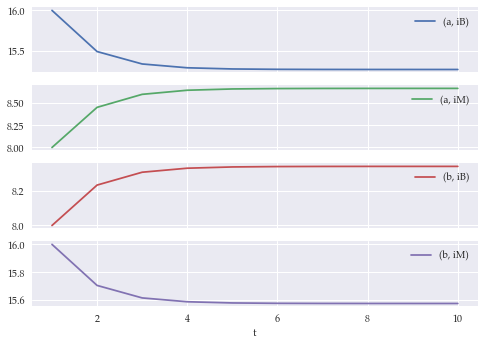

In [11]:
gpyDB_wheels.adj.rc_pd(mCalib.out_db.get('qD'), P.get('dur')).unstack('s').unstack('n').plot(subplots=True);

### 5. Export 

In [12]:
P.s.db = mCalib.out_db
P.s.setstate('B')

Export:

In [13]:
with open(os.path.join(d['data'], P.name), "wb") as file:
    pickle.dump(P,file)